## 7.1 Autoencoder and Variational Autoencoder

* Autoencoder(AE)又稱為自編碼器，由兩個具有對稱結構的函數構成，一個函數負責壓縮，另一個負責合成還原。
* 好處：減少資料維度，增加運算速度。

![AE](7_1.jpg)



### (1)初始準備

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Keras function
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import Dense, Activation, Lambda
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras datasets
from keras.datasets import mnist

#Keras utilis function
from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


In [3]:
# 把mnist load 進來
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.reshape(60000,784)
x_test=x_test.reshape(10000,784)

# 把每個像素的值從(0~255)->(0, 1)
x_train= x_train/255
x_test=x_test/255

### AE結構

In [4]:
enc_1=Dense(100, activation='sigmoid')
enc_2=Dense(2, activation='sigmoid')

dec_2=Dense(100, activation='sigmoid')
dec_1=Dense(784, activation='sigmoid')

In [5]:
x = Input(shape=(784,))

In [6]:
enc_x= enc_1(x)
h = enc_2(enc_x)

dec_x = dec_2(h)
x_restructed= dec_1(dec_x)

In [7]:
autoencoder = Model(x, x_restructed)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


In [8]:
autoencoder.compile(loss='kullback_leibler_divergence', optimizer='Nadam')

In [ ]:
autoencoder.fit(x_train, x_train, batch_size=32, epochs=100)

In [11]:
autoencoder.load_weights('autoencoder_handwriting_model_weights.h5')

## 7.2 視覺化-子模型的取出

In [12]:
Encoder = Model(x,h)
Encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [13]:
h_input= Input(shape=(2,))
Decoder = Model(h_input, dec_1(dec_2(h_input)))
Decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


### ENCODER

In [14]:
x_train.shape[0]

60000

In [15]:
# 將784維的圖轉換為二維的點
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, Encoder.predict(x_train[idx: idx+1])))

第 25424 圖的 latent 表示為 [[0.21600133 0.10749797]]


In [16]:
indices = np.random.randint(x_test.shape[0], size=3000)

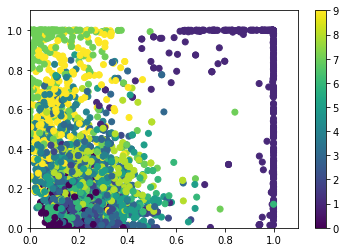

In [19]:
latent = Encoder.predict(x_test[indices])
plt.scatter(latent[:,0], latent[:,1], c=y_test[indices])
plt.colorbar()
plt.axis([0, 1.1, 0, 1.1])
plt.show()

* **autoencoder降維過程後，分群效果並不良好，因此需要使用VAE。**

### DECODER

In [20]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [21]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

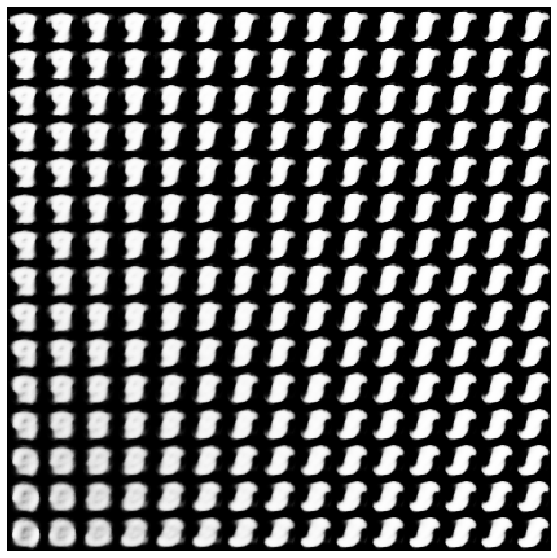

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

* Decoder還原後效果並不良好，可能原因：
    1. 權重不好，訓練不夠
    2. 沒有道理可以用2維分類0~9的位置
    3. AE層數不夠深

## 7.3 VAE(Variational Autoencoder)

* VAE：
 有別於AE，Decoder還原自encoder降維的結果。在VAE中，encoder與decoder並非相連，而是中間透過encoder學習到的常態分配，再進行還原。

![VAE](7_2.jpg)

### VAE的建立

In [23]:
enc_1 = Dense(100, activation='sigmoid')
# enc_2 = Dense(2, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [24]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [25]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [26]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [27]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [28]:
VAE = Model(x, x_hat)
VAE.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          78500       input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            202         dense_5[0][0]                    
____________________________________________________________________________________________

## 7.4 VAE的Loss函數建立

VAE 的loss函數關乎訊息理論 (information theory) 的知識。

若對 VAE 的理論及模型基本設定可參考下列兩篇論文：

    Auto-Encoding Variational Bayes:  https://arxiv.org/pdf/1312.6114.pdf
    Tutorial on Variational Autoencoders:  https://arxiv.org/pdf/1606.05908.pdf


In [29]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

## 7.5 VAE的訓練

In [30]:
VAE.compile(loss=vae_loss, optimizer=Adam())

In [ ]:
VAE.fit(x_train, x_train, batch_size=32, epochs=100)

In [31]:
# VAE.save_weights('VAE_handwriting_model_weights.h5')
VAE.load_weights('VAE_handwriting_model_weights.h5')

## 7.6 VAE的視覺化

In [32]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [33]:
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


### ENCODE視覺化

In [34]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 1768 圖的 latent 表示為 [[-0.03513524 -1.1432359 ]]


In [35]:
# indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

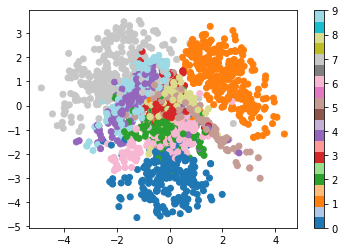

In [37]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test[indices], cmap='tab20')
plt.colorbar()
plt.show()

### DECODE視覺化

In [38]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [39]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

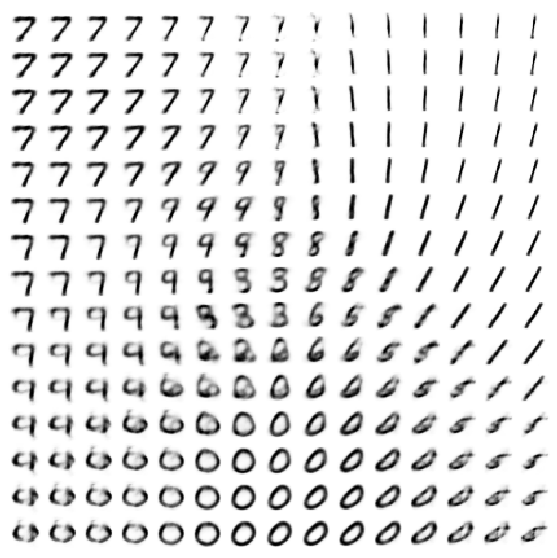

In [40]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

## 7.7 與 Autoencoder 的 Encoder 進行視覺化比較

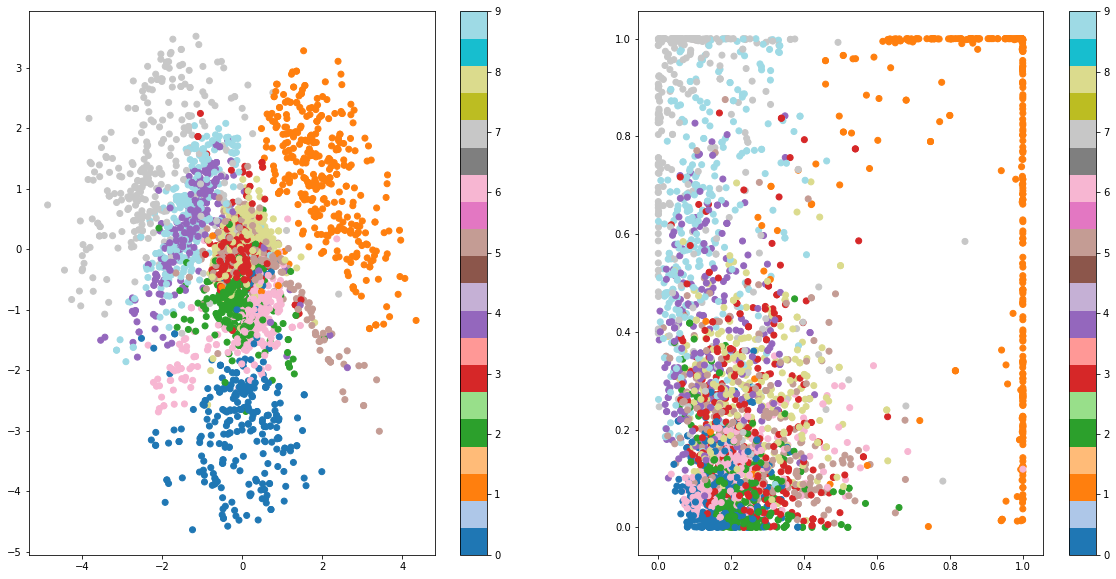

In [43]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test[indices], cmap='tab20')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(latent[:, 0], latent[:, 1], c=y_test[indices], cmap='tab20')
plt.colorbar()
plt.show()

## 7.8 動態比較

In [ ]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [ ]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

In [ ]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))